<a href="https://colab.research.google.com/github/Parsa-jay/hybrid-Recommendation-system-using-deep-learning/blob/main/Final_code_RNN_Checkpoint_SVD_PCA_CNN_WithRepeatVector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# downgrading numpy cause of interference with surprise package
!pip uninstall -y numpy
!pip install numpy==1.26.4


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469544 sha256=42345d8045166bb52fc519a1e50a3897c5bce701f0dfdd726b74b2e6afa71246
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
!pip install xgboost lightgbm scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

import xgboost as xgb

from surprise import Dataset, Reader, SVD     #new
from surprise.model_selection import cross_validate   #new

import matplotlib.pyplot as plt # Import matplotlib for plotting

import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras import optimizers

In [ ]:
!unzip -qq ml-100k.zip

 --- Data Loading and Preprocessing Function (Included for Self-Containment) ---


In [ ]:
# new
# if only-movies-factor -> factor_mode=0 , only-user-factor -> factor_mode=1, user-movies-factor -> factor_mode=2
def factors_col_for_input_update(factor_mode=2,item_factors_col=[],user_factors_col=[]):
  if factor_mode == 0:
    factors_col_for_input = item_factors_col
  elif factor_mode == 1:
    factors_col_for_input = user_factors_col
  elif factor_mode == 2:
    factors_col_for_input = item_factors_col + user_factors_col
    print('it works')
  else:
    factors_col_for_input = []
  return factors_col_for_input

In [32]:
#New
#Extraxting users and items latent factor from user-item matrix using svd (collabrative information)
def extract_latent_factors(ratings_df, n_factors, n_epochs, n_components_pca):
  reader = Reader(rating_scale=(1, 5))  # Ratings range from 1 to 5
  data_surprise = Dataset.load_from_df(ratings_df[["user_id", "movie_id", "rating"]], reader)

  svd_model = SVD(n_factors=n_factors, n_epochs=n_epochs)
  cross_validate(svd_model, data_surprise, cv=5, verbose=True)
  trainset = data_surprise.build_full_trainset()
  svd_model.fit(trainset)
  pca = PCA(n_components=n_components_pca, random_state=42)
  scaler = StandardScaler()

  # 1. Extract item latent factors and store them in a variable
  item_latent_factors = svd_model.qi
  item_latent_factors = scaler.fit_transform(item_latent_factors)
  item_latent_factors = pca.fit_transform(item_latent_factors)
  print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_.sum():.2f}")
  # The shape of item_latent_factors will be (n_items_in_trainset, n_factors)
  users_latent_factors = svd_model.pu
  scaler = StandardScaler()
  users_latent_factors = scaler.fit_transform(users_latent_factors)
  users_latent_factors = pca.fit_transform(users_latent_factors)
  print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_.sum():.2f}")

  print("Shape of item_latent_factors:", item_latent_factors.shape)
  print("Shape of users_latent_factors:", users_latent_factors.shape)

  raw_movie_ids = [trainset.to_raw_iid(inner_id) for inner_id in trainset.all_items()]
  # Map inner user IDs to raw user_ids
  raw_user_ids = [trainset.to_raw_uid(inner_id) for inner_id in trainset.all_users()]

  # Create a DataFrame for the item latent factors
  item_factors_df = pd.DataFrame(item_latent_factors,
                               columns=[f'factor_{i+1}' for i in range(n_components_pca)])
  item_factors_col_names = item_factors_df.columns.tolist()
  item_factors_df['movie_id'] = raw_movie_ids

  # Create a DataFrame for the user latent factors
  user_factors_df = pd.DataFrame(users_latent_factors,
                                columns=[f'user_factor_{i+1}' for i in range(n_components_pca)])
  user_factors_col_names = user_factors_df.columns.tolist()
  user_factors_df['user_id'] = raw_user_ids


  # Reorder columns to have movie_id first
  item_factors_df = item_factors_df[['movie_id'] + [f'factor_{i+1}' for i in range(n_components_pca)]]

  # Reorder columns to have user_id first
  user_factors_df = user_factors_df[['user_id'] + [f'user_factor_{i+1}' for i in range(n_components_pca)]]

  print("\nDataFrame of item latent factors (first 5 rows):\n", item_factors_df.head())
  print("\nDataFrame of users latent factors (first 5 rows):\n", user_factors_df.head())

  factors_col_for_input = factors_col_for_input_update(factor_mode=2,item_factors_col=item_factors_col_names,user_factors_col=user_factors_col_names)

  return item_factors_df, user_factors_df, factors_col_for_input


In [39]:

# --- Data Loading and Preprocessing Function (Included for Self-Containment) ---
def load_and_preprocess_movielens_data(data_path='./ml-100k/'):
    """
    Loads, preprocesses, and prepares the MovieLens 100K dataset for classification.

    Args:
        data_path (str): The path to the directory containing the MovieLens 100K files
                         (e.g., 'u.data', 'u.item').

    Returns:
        tuple: A tuple containing:
            - X_train (pd.DataFrame): Training features.
            - X_test (pd.DataFrame): Testing features.
            - y_train (pd.Series): Training target (0-indexed ratings).
            - y_test (pd.Series): Testing target (0-indexed ratings).
            - num_users (int): Total number of unique users.
            - num_movies (int): Total number of unique movies.
            - num_classes (int): Number of rating classes (e.g., 5 for 1-5 stars).
    """
    # --- 1. Load Ratings Data (u.data) ---
    u_data_file = os.path.join(data_path, 'u.data')
    try:
        ratings_df = pd.read_csv(
            u_data_file,
            sep='\t',
            header=None,
            names=['user_id', 'movie_id', 'rating', 'timestamp']
        )
        print("Ratings DataFrame loaded successfully. (u.data)")
        print(ratings_df.head())
        print(f"Number of ratings: {len(ratings_df)}")
    except FileNotFoundError:
        print(f"Error: File {u_data_file} not found. Please check the path.")
        return None, None, None, None, None, None, None

    # --- 1.5. extracting movies & users latent factors
    item_factors_df, user_factors_df, factors_col_for_input = extract_latent_factors(ratings_df, n_factors=24, n_epochs=40, n_components_pca=9) #new


    # --- 2. Load Movie Information (u.item) ---
    movie_cols = [
        'movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url',
        'unknown_genre', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ]
    u_item_file = os.path.join(data_path, 'u.item')
    try:
        movies_df = pd.read_csv(
            u_item_file,
            sep='|',
            header=None,
            encoding='latin-1',
            names=movie_cols
        )
        print("\nMovies DataFrame loaded successfully. (u.item)")
        print(movies_df.head())
        print(f"Number of movies: {len(movies_df)}")
    except FileNotFoundError:
        print(f"Error: File {u_item_file} not found. Please check the path.")
        return None, None, None, None, None, None, None

    # --- 3. Merge Ratings and Movies Data ---
    data_df = pd.merge(ratings_df, movies_df, on='movie_id', how='left')
    print("\nMerged DataFrame (ratings + movies) created.")
    print(data_df.head())
    print(f"Number of rows in merged DataFrame: {len(data_df)}")

    #new
    data_df = pd.merge(data_df, item_factors_df, on='movie_id', how='left')
    print("\nMerged DataFrame (ratings + movies + item factors) created.")
    print(data_df.head()) # You should now see 'factor_X' columns

    #new
    data_df = pd.merge(data_df, user_factors_df, on='user_id', how='left')
    print("\nMerged DataFrame (ratings + movies + user factors) created.")
    print(data_df.head()) # You should now see 'user_factor_X' columns

    # --- 4. Preprocessing and Feature Engineering ---
    user_encoder = LabelEncoder()
    data_df['user_id_encoded'] = user_encoder.fit_transform(data_df['user_id'])
    movie_encoder = LabelEncoder()
    data_df['movie_id_encoded'] = movie_encoder.fit_transform(data_df['movie_id'])

    num_users = len(user_encoder.classes_)
    num_movies = len(movie_encoder.classes_)

    data_df['release_year'] = pd.to_datetime(data_df['release_date'], errors='coerce').dt.year
    data_df['release_year'].fillna(data_df['release_year'].median(), inplace=True)
    data_df['release_year'] = data_df['release_year'].astype(int)

    genre_cols = [
        'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ]


    features = ['user_id_encoded', 'movie_id_encoded', 'release_year'] + factors_col_for_input + genre_cols #Modified because of svd
    X = data_df[features]

    y = data_df['rating'] - 1
    num_classes = y.nunique()


    scaler = StandardScaler()
    X['release_year'] = scaler.fit_transform(X[['release_year']])


    print("\nProcessed X (features) ready:")
    print(X.head())
    print(f"Shape of X: {X.shape}")
    print("\nProcessed y (target) ready:")
    print(y.head())
    print(f"Shape of y: {y.shape}")
    print(f"Number of unique users: {num_users}")
    print(f"Number of unique movies: {num_movies}")
    print(f"Number of rating classes (0-indexed): {num_classes}")

    # --- 5. Split Data into Training and Testing Sets ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    print(f"\nShape of training set (X_train, y_train): {X_train.shape}, {y_train.shape}")
    print(f"Shape of test set (X_test, y_test): {X_test.shape}, {y_test.shape}")

    return X_train, X_test, y_train, y_test, num_users, num_movies, num_classes, factors_col_for_input




 --- Classifier Model Definition ---

In [ ]:
# --- Classifier Model Definition ---   #new argumants num_movie_factor, num_user_factor
def build_full_classifier_model(num_users, num_movies, num_genres, num_movie_factor, num_user_factor, num_classes, embedding_dim=50, dense_units=128, feature_vector_dim_before_classifier=64):
    """
    Builds the full classifier model, including feature extraction branches
    and a final classification head. Adapted for 1D tabular data.

    Args:
        num_users (int): Total number of unique users.
        num_movies (int): Total number of unique movies.
        num_genres (int): Number of genre features (e.g., 19 for MovieLens 100K).
        num_classes (int): Number of output classes for classification (e.g., 5 for 1-5 stars).
        embedding_dim (int): Dimension for user and movie embeddings.
        dense_units (int): Number of units in the Dense layers.
        feature_vector_dim_before_classifier (int): Dimension of the feature vector
                                                      before the final classification layer.

    Returns:
        keras.Model: The TensorFlow Keras model for classification.
    """

    # --- 1. Define Inputs ---
    user_input = keras.Input(shape=(1,), name='user_id_input')
    movie_input = keras.Input(shape=(1,), name='movie_id_input')
    movie_features_input = keras.Input(shape=(1 + num_genres +num_movie_factor + num_user_factor,), name='movie_features_input')    #Modified because of svd

    # --- 2. Embedding Layers for User and Movie IDs ---
    user_embedding = layers.Embedding(
        input_dim=num_users,
        output_dim=embedding_dim,
        input_length=1,
        name='user_embedding'
    )(user_input)
    user_embedding = layers.Flatten()(user_embedding)

    movie_embedding = layers.Embedding(
        input_dim=num_movies,
        output_dim=embedding_dim,
        input_length=1,
        name='movie_embedding'
    )(movie_input)
    movie_embedding = layers.Flatten()(movie_embedding)

    # --- 3. Concatenate all primary features ---
    concatenated_primary_features = layers.concatenate([
        user_embedding,
        movie_embedding,
        movie_features_input
    ], name='concatenated_primary_features')

    total_features_dim = embedding_dim * 2 + (1 + num_genres + num_user_factor + num_movie_factor)    #Modified because of svd

    # --- 4. Branch 1: Using RepeatVector layer, we make a sample of shape (3, total_features_dim)
    # which enable us to use 1 dim conv layers, and we add BatchNormalization for regularization
    # and an AveragePooling layer for reducing dimension

    x1 = layers.RepeatVector(3, name="repeat_vector")(concatenated_primary_features)

    x1 = layers.Conv1D(128, 3, activation='relu', name='conv_like_1_complex', padding='same')(x1)
    x1 = layers.BatchNormalization(name='bn_conv_like_1_complex')(x1)

    x1 = layers.AveragePooling1D(2)(x1)

    x1 = layers.Flatten(name='flatten_complex')(x1)

    # --- 5. Branch 2: More Complex Stacked SimpleRNN Stream ---
    # SimpleRNN expects a 3D input (batch_size, timesteps, features).
    # We reshape our 1D concatenated features to (batch_size, 1, total_features_dim)
    # to simulate a single timestep sequence for the first SimpleRNN layer.
    x2 = layers.Reshape((1, total_features_dim), name='rnn_input_reshape')(concatenated_primary_features)

    # First LSTM layer: return sequences for the next LSTM layer
    x2 = layers.LSTM(dense_units, activation='relu', return_sequences=True, name='lstm_layer_1')(x2)
    x2 = layers.BatchNormalization(name='bn_lstm_1')(x2) # Added BatchNormalization
    x2 = layers.Dropout(0.3, name='dropout_lstm_1')(x2)

    # Second LSTM layer: return sequences for the next LSTM layer
    x2 = layers.LSTM(dense_units // 2, activation='relu', return_sequences=True, name='lstm_layer_2')(x2)
    x2 = layers.BatchNormalization(name='bn_lstm_2')(x2) # Added BatchNormalization
    x2 = layers.Dropout(0.3, name='dropout_lstm_2')(x2)

    # Third LSTM layer: return only the last output (default behavior for last LSTM in stack)
    x2 = layers.LSTM(dense_units // 4, activation='relu', name='lstm_layer_3')(x2) # Reduced units, no return_sequences
    x2 = layers.BatchNormalization(name='bn_lstm_3')(x2) # Added BatchNormalization
    x2 = layers.Dropout(0.3, name='dropout_lstm_3')(x2)

    # Additional Dense layers after LSTM output
    x2 = layers.Dense(dense_units // 2, activation='relu', name='dense_rnn_1_complex')(x2)
    x2 = layers.Dropout(0.2, name='dropout_rnn_2_complex')(x2)
    x2 = layers.Dense(dense_units // 4, activation='relu', name='dense_rnn_2_complex')(x2) # Added another Dense layer



    # --- 6. Concatenate Outputs of Both Branches ---
    merged_features = layers.concatenate([x1, x2], name='merged_branches_features')

    # --- 7. Final Dense Layers for Feature Extraction (before classifier head) ---
    # These layers further process the merged features to create the final
    # optimized feature representation (output of dense_3 in diagram).
    dense_output_1 = layers.Dense(dense_units, activation='relu', name='dense_1')(merged_features)
    dense_output_1 = layers.BatchNormalization(name='bn_dense_1')(dense_output_1) # Added BN
    dense_output_1 = layers.Dropout(0.3, name='dropout_dense_1')(dense_output_1)

    dense_output_2 = layers.Dense(dense_units // 2, activation='relu', name='dense_2')(dense_output_1)
    dense_output_2 = layers.BatchNormalization(name='bn_dense_2')(dense_output_2) # Added BN
    dense_output_2 = layers.Dropout(0.2, name='dropout_dense_2')(dense_output_2)

    # This layer holds the extracted features, which will be the output of the feature extractor model
    extracted_features_output_layer = layers.Dense(feature_vector_dim_before_classifier, activation='relu', name='extracted_features_output_layer')(dense_output_2)
    extracted_features_output_layer = layers.BatchNormalization(name='bn_extracted_features')(extracted_features_output_layer) # Added BN
    extracted_features_output_layer = layers.Dropout(0.1, name='dropout_extracted_features')(extracted_features_output_layer) # Adjusted dropout

    # --- 8. Classification Head ---
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(extracted_features_output_layer)

    # Define the full classifier model
    model = keras.Model(
        inputs=[user_input, movie_input, movie_features_input],
        outputs=classification_output,
        name='full_classifier_model'
    )

    return model

Feature extraction model

In [ ]:
def get_feature_extractor_model(full_classifier_model):
    """
    Extracts the feature extraction part of the full classifier model.

    Args:
        full_classifier_model (keras.Model): The full trained classifier model.

    Returns:
        keras.Model: A new model that outputs the features extracted by the
                     'extracted_features_output_layer' of the classifier model.
    """
    # Get the output tensor of the layer that contains the extracted features
    feature_extractor_output = full_classifier_model.get_layer('extracted_features_output_layer').output

    # Create a new model with the same inputs as the classifier,
    # but with the extracted features layer as its output.
    feature_extractor_model = keras.Model(
        inputs=full_classifier_model.inputs,
        outputs=feature_extractor_output,
        name='feature_extractor_model'
    )
    return feature_extractor_model

In [ ]:


def evaluate_classification_metrics(y_true, y_pred, model_str, data_str):
    """
    Calculates and prints accuracy, precision, recall, and F1-score for multiclass classification.
    Also plots the confusion matrix.

    Args:
        y_true (array-like): True labels (integer form).
        y_pred (array-like): Predicted labels (integer form).
        model_str (string): model name.
        data_str (string): data type (test or train)
    """
    # Ensure inputs are numpy arrays for consistent indexing/operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape.")

    print("\n--- Classification Metrics ---")

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1-score for multiclass
    # 'weighted' average accounts for class imbalance by computing metrics for each label,
    # and finding their average weighted by support (the number of true instances for each label).
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-score: {f1:.4f}")

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d', # Format as integer
        cmap='Blues',
        cbar=True
    )
    plot_title = 'Confusion matrix: '+ model_str + ', for '+ data_str
    plt.title(plot_title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    print(f"\nConfusion matrix plot displayed for '{plot_title}'.")

    return accuracy, precision, recall, f1

Usage

In [40]:
print("Loading and preprocessing MovieLens 100K data...")
X_train, X_test, y_train, y_test, num_users, num_movies, num_classes, factors_col_for_input = load_and_preprocess_movielens_data()

Loading and preprocessing MovieLens 100K data...
Ratings DataFrame loaded successfully. (u.data)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
Number of ratings: 100000
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9381  0.9554  0.9468  0.9456  0.9503  0.9473  0.0057  
MAE (testset)     0.7326  0.7473  0.7416  0.7401  0.7419  0.7407  0.0047  
Fit time          1.69    2.20    1.79    1.69    1.78    1.83    0.19    
Test time         0.15    0.18    0.09    0.10    0.49    0.20    0.15    
Explained variance ratio by PCA components: 0.51
Explained variance ratio by PCA components: 0.52
Shape of item_latent_factors: (1682, 9)
Shape of users_latent_factors: (943, 9)

DataFrame of item latent fact

/tmp/ipython-input-39-3563302469.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df['release_year'].fillna(data_df['release_year'].median(), inplace=True)
/tmp/ipython-input-39-3563302469.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['release_year'] = scaler.fit_trans

In [41]:
# Prepare inputs for the Keras model from X_train
user_ids_input_train = X_train['user_id_encoded'].values
movie_ids_input_train = X_train['movie_id_encoded'].values

genre_cols_for_input = [
    'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

movie_features_input_train = X_train[['release_year'] + factors_col_for_input + genre_cols_for_input].values  #Modified because of svd

# --- Build the full classifier model ---

In [42]:
# --- Build the full classifier model ---
print("\nBuilding the FULL CLASSIFIER MODEL...")
full_classifier_model = build_full_classifier_model(
    num_users=num_users,
    num_movies=num_movies,
    num_genres=len(genre_cols_for_input),
    num_user_factor=9,  #new
    num_movie_factor=9, #new
    num_classes=num_classes, # Pass num_classes for the output layer
    embedding_dim=50,
    dense_units=128,
    feature_vector_dim_before_classifier=64 # Dimension of features before classification
)

# Print model summary for the full classifier
print("\nSummary of the FULL CLASSIFIER MODEL:")
full_classifier_model.summary()

# --- Plot the full classifier model structure ---
try:
    keras.utils.plot_model(
        full_classifier_model,
        to_file='full_classifier_model_CNNRNN.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    print("\nFull classifier model plot saved to 'full_classifier_model_plot.png'")
except ImportError:
    print("\nWarning: pydot and/or graphviz not found for full classifier model plot.")
    print("Please install them to visualize the model: pip install pydot graphviz")
    print("You might also need to install Graphviz executables on your system.")
except Exception as e:
    print(f"\nAn error occurred while plotting the full classifier model: {e}")



Building the FULL CLASSIFIER MODEL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Summary of the FULL CLASSIFIER MODEL:


Model: "full_classifier_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     47,150 │ user_id_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │     84,100 │ movie_id_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_features_inp… │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated_prima… │ (None, 137)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ movie_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_input_reshape   │ (None, 1, 137)    │          0 │ concatenated_pri… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 1, 128)    │    136,192 │ rnn_input_reshap… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_1           │ (None, 1, 128)    │        512 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_lstm_1      │ (None, 1, 128)    │          0 │ bn_lstm_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 1, 64)     │     49,408 │ dropout_lstm_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_2           │ (None, 1, 64)     │        256 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_lstm_2      │ (None, 1, 64)     │          0 │ bn_lstm_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_3 (LSTM) │ (None, 32)        │     12,416 │ dropout_lstm_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 3, 137)    │          0 │ concatenated_pri… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_3           │ (None, 32)        │        128 │ lstm_layer_3[0][… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 421,975 (1.61 MB)

 Trainable params: 420,759 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)


Full classifier model plot saved to 'full_classifier_model_plot.png'


# --- Compile and Train the full_classifier_model ---

In [ ]:
#new
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return 0.00005

In [43]:
# --- Compile and Train the full_classifier_model ---
print("\nCompiling the FULL CLASSIFIER MODEL...")
full_classifier_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), #Modified
    loss='sparse_categorical_crossentropy', # Use for integer labels (0-4)
    metrics=['accuracy']
)

print("\nTraining the FULL CLASSIFIER MODEL...")
# Prepare test inputs for validation during training
user_ids_input_test = X_test['user_id_encoded'].values
movie_ids_input_test = X_test['movie_id_encoded'].values
movie_features_input_test = X_test[['release_year'] + factors_col_for_input + genre_cols_for_input].values  #Modified because of svd

callbacks = [keras.callbacks.LearningRateScheduler(scheduler), keras.callbacks.ModelCheckpoint("best_one.keras", 'val_accuracy', save_best_only=True)]  #new

history = full_classifier_model.fit(
    [user_ids_input_train, movie_ids_input_train, movie_features_input_train],
    y_train,
    epochs=30, # You can adjust the number of epochs
    batch_size=128, # You can adjust the batch size
    validation_split=0.2, # Use 20% of training data as validation data
    callbacks=callbacks,
    verbose=1 # Show training progress
)
print("\nTraining of FULL CLASSIFIER MODEL complete.")


Compiling the FULL CLASSIFIER MODEL...

Training the FULL CLASSIFIER MODEL...
Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.2230 - loss: 2.0278 - val_accuracy: 0.3163 - val_loss: 1.5242 - learning_rate: 1.0000e-04
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.2940 - loss: 1.6416 - val_accuracy: 0.3559 - val_loss: 1.4231 - learning_rate: 1.0000e-04
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.3284 - loss: 1.5246 - val_accuracy: 0.3708 - val_loss: 1.3902 - learning_rate: 5.0000e-05
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.3456 - loss: 1.4785 - val_accuracy: 0.3784 - val_loss: 1.3653 - learning_rate: 5.0000e-05
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.3543 - loss: 1.4477 - val_accuracy: 0.3885 - val_loss: 1.3417 - learning_rate: 5.0000e-05
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.3680 - loss: 1.4107 - val_accuracy: 0.3965 - val_loss: 1.3205 -

# --- Plot training history (loss and accuracy) ---


Plotting training history...


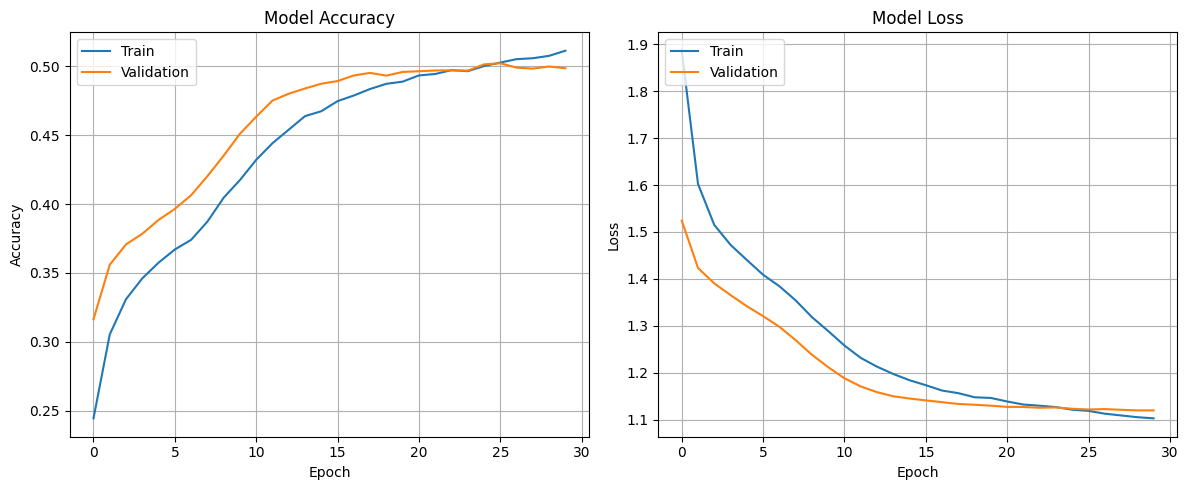

Training history plot saved to 'training_history_plot.png'


In [44]:
# --- Plot training history (loss and accuracy) ---
print("\nPlotting training history...")
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history_CNNRNN.png') # Save the plot to a file
plt.show() # Display the plot
print("Training history plot saved to 'training_history_plot.png'")

# Evaluate the model

On the test set


Evaluating the FULL CLASSIFIER MODEL on the test set...
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

--- Classification Metrics ---
Accuracy: 0.5018
Weighted Precision: 0.5084
Weighted Recall: 0.5018
Weighted F1-score: 0.4972


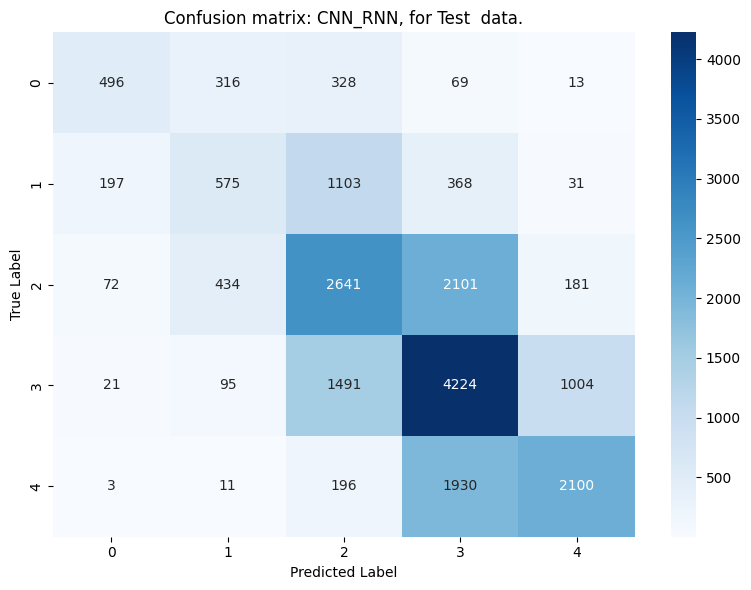


Confusion matrix plot displayed for 'Confusion matrix: CNN_RNN, for Test  data.'.
Full Classifier Test Loss: 1.1162
Full Classifier Test Accuracy: 0.5018


In [45]:
# Evaluate the model on the test set
print("\nEvaluating the FULL CLASSIFIER MODEL on the test set...")
full_classifier_model = keras.models.load_model("best_one.keras") #Modified because of model checkpoint
Full_Classifier_Test_predict =full_classifier_model.predict( [user_ids_input_test, movie_ids_input_test, movie_features_input_test])
Full_Classifier_Test_predict = np.array(Full_Classifier_Test_predict)
y_true_int_test = np.array(y_test)
y_pred_int_test = np.argmax(Full_Classifier_Test_predict,  axis=1)
model_str = 'CNN_RNN'
data_str = 'Test  data.'
evaluate_classification_metrics(y_true_int_test, y_pred_int_test, model_str, data_str)
loss, accuracy = full_classifier_model.evaluate(
    [user_ids_input_test, movie_ids_input_test, movie_features_input_test],
    y_test,
    verbose=0
)
print(f"Full Classifier Test Loss: {loss:.4f}")
print(f"Full Classifier Test Accuracy: {accuracy:.4f}")

In [ ]:
# Evaluate the model on the train set
print("\nEvaluating the FULL CLASSIFIER MODEL on the train set...")
full_classifier_model = keras.models.load_model("best_one.keras") #Modified because of model checkpoint
Full_Classifier_Train_predict =full_classifier_model.predict([user_ids_input_train, movie_ids_input_train, movie_features_input_train])
Full_Classifier_Train_predict = np.array(Full_Classifier_Train_predict)
y_train_oh = np.array(y_train)
y_pred_int_train = np.argmax(Full_Classifier_Train_predict,  axis=1)
model_str = 'CNN_RNN'
data_str = 'Train  data.'
evaluate_classification_metrics(y_train_oh, y_pred_int_train, model_str, data_str)
loss, accuracy = full_classifier_model.evaluate(
    [user_ids_input_train, movie_ids_input_train, movie_features_input_train],
    y_train,
    verbose=0
)
print(f"Full Classifier Train Loss: {loss:.4f}")
print(f"Full Classifier Train Accuracy: {accuracy:.4f}")


Evaluating the FULL CLASSIFIER MODEL on the train set...
  44/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

KeyboardInterrupt: 

# --- Get the feature extractor model from the full classifier ---

In [46]:
# --- Get the feature extractor model from the full classifier ---
print("\nExtracting the FEATURE EXTRACTOR MODEL from the classifier...")
feature_extractor_model = get_feature_extractor_model(keras.models.load_model("best_one.keras"))  #Modified because of model checkpoint

# Print model summary for the feature extractor
print("\nSummary of the FEATURE EXTRACTOR MODEL:")
feature_extractor_model.summary()

# --- Plot the feature extractor model structure ---
try:
    keras.utils.plot_model(
        feature_extractor_model,
        to_file='feature_extractor_model_CNNRNN.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB'
    )
    print("\nFeature extractor model plot saved to 'feature_extractor_model_plot.png'")
except ImportError:
    print("\nWarning: pydot and/or graphviz not found for feature extractor model plot.")
    print("Please install them to visualize the model: pip install pydot graphviz")
    print("You might also need to install Graphviz executables on your system.")
except Exception as e:
    print(f"\nAn error occurred while plotting the feature extractor model: {e}")



Extracting the FEATURE EXTRACTOR MODEL from the classifier...

Summary of the FEATURE EXTRACTOR MODEL:


Model: "feature_extractor_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     47,150 │ user_id_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │     84,100 │ movie_id_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_features_inp… │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenated_prima… │ (None, 137)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ movie_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_input_reshape   │ (None, 1, 137)    │          0 │ concatenated_pri… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 1, 128)    │    136,192 │ rnn_input_reshap… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_1           │ (None, 1, 128)    │        512 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_lstm_1      │ (None, 1, 128)    │          0 │ bn_lstm_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 1, 64)     │     49,408 │ dropout_lstm_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_2           │ (None, 1, 64)     │        256 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_lstm_2      │ (None, 1, 64)     │          0 │ bn_lstm_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_3 (LSTM) │ (None, 32)        │     12,416 │ dropout_lstm_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 3, 137)    │          0 │ concatenated_pri… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_lstm_3           │ (None, 32)        │        128 │ lstm_layer_3[0][… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 421,394 (1.61 MB)

 Trainable params: 420,306 (1.60 MB)

 Non-trainable params: 1,088 (4.25 KB)


Feature extractor model plot saved to 'feature_extractor_model_plot.png'


# --- Example of using the feature extractor ---

In [47]:
# --- Example of using the feature extractor ---
print("\nExtracting features from training data using the feature extractor model...")
pca = PCA(32,random_state=42) #NEW _ reducing extracted features dimension to train svm more efficiently
extracted_features_train = feature_extractor_model.predict([user_ids_input_train, movie_ids_input_train, movie_features_input_train])
extracted_features_train = pca.fit_transform(extracted_features_train)
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_.sum():.2f}")

print(f"\nShape of extracted training features (ready for SVM): {extracted_features_train.shape}")
print("Sample of extracted training features (first 5 rows):")

# --- How to use with SVM ---
# Now that the full classifier model is trained, you can use the extracted features
# to train your SVM model.

# Example of preparing test data for prediction (if you want to evaluate SVM later)
user_ids_input_test = X_test['user_id_encoded'].values
movie_ids_input_test = X_test['movie_id_encoded'].values
movie_features_input_test = X_test[['release_year'] + factors_col_for_input + genre_cols_for_input].values  #Modified because of svd

print("\nExtracting features from test data using the feature extractor model...")
extracted_features_test = feature_extractor_model.predict([user_ids_input_test, movie_ids_input_test, movie_features_input_test])
print(f"Shape of extracted test features (ready for SVM): {extracted_features_test.shape}")
extracted_features_test = pca.fit_transform(extracted_features_test)
print(f"Shape of extracted test features with rediuced dim (ready for SVM): {extracted_features_test.shape}")
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_.sum():.2f}")


Extracting features from training data using the feature extractor model...
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step
Explained variance ratio by PCA components: 0.95

Shape of extracted training features (ready for SVM): (80000, 32)
Sample of extracted training features (first 5 rows):

Extracting features from test data using the feature extractor model...
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Shape of extracted test features (ready for SVM): (20000, 64)
Shape of extracted test features with rediuced dim (ready for SVM): (20000, 32)
Explained variance ratio by PCA components: 0.95


# Classic machine learning models

In [ ]:


# Example SVM usage (uncomment and run if you have scikit-learn installed)
from sklearn.svm import SVC
from sklearn.metrics import classification_report

print("\nTraining a sample SVM model on extracted features...")
svm_model = SVC(random_state=42, kernel= "rbf")
svm_model.fit(extracted_features_train, y_train)

svm_train_accuracy = svm_model.score(extracted_features_train, y_train)
svm_test_accuracy = svm_model.score(extracted_features_test, y_test)

print(f"SVM Training Accuracy (on extracted features): {svm_train_accuracy:.4f}")
print(f"SVM Test Accuracy (on extracted features): {svm_test_accuracy:.4f}")

y_pred_test_svm = svm_model.predict(extracted_features_test)
print("\nClassification Report for SVM on Extracted Test Data:")
print(classification_report(y_test, y_pred_test_svm))


In [ ]:
#svm_train_predict = svm_model.predict(extracted_features_train)
svm_test_predict = svm_model.predict(extracted_features_test)

In [ ]:
model_str = 'SVM (CNN_RNN)'
data_str = 'Test data.'
evaluate_classification_metrics(y_true_int_test, svm_test_predict, model_str, data_str)

In [ ]:
# model_str = 'SVM (CNN_RNN), '
# data_str = 'Train data.'
# evaluate_classification_metrics(y_train_oh, svm_train_predict, model_str, data_str)

In [48]:
# Example RF usage (uncomment and run if you have scikit-learn installed) RF with PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier

print("\nTraining a sample Random Forest model on extracted features...")

# You can adjust n_estimators, max_depth, etc., if you want
rf_model = RandomForestClassifier(random_state=42, n_estimators=400, max_depth=15, min_samples_leaf=2, min_samples_split=3,)
rf_model.fit(extracted_features_train, y_train)

rf_train_accuracy = rf_model.score(extracted_features_train, y_train)
rf_test_accuracy = rf_model.score(extracted_features_test, y_test)

print(f"Random Forest Training Accuracy (on extracted features): {rf_train_accuracy:.4f}")
print(f"Random Forest Test Accuracy (on extracted features): {rf_test_accuracy:.4f}")

y_pred_test_rf = rf_model.predict(extracted_features_test)
print("\nClassification Report for Random Forest on Extracted Test Data:")
print(classification_report(y_test, y_pred_test_rf))



Training a sample Random Forest model on extracted features...
Random Forest Training Accuracy (on extracted features): 0.7101
Random Forest Test Accuracy (on extracted features): 0.5024

Classification Report for Random Forest on Extracted Test Data:
              precision    recall  f1-score   support

           0       0.65      0.40      0.50      1222
           1       0.41      0.25      0.31      2274
           2       0.46      0.48      0.47      5429
           3       0.48      0.63      0.55      6835
           4       0.63      0.50      0.56      4240

    accuracy                           0.50     20000
   macro avg       0.53      0.45      0.48     20000
weighted avg       0.51      0.50      0.50     20000



In [49]:
#rf_train_predict = rf_model.predict(extracted_features_train)
rf_test_predict = rf_model.predict(extracted_features_test)


--- Classification Metrics ---
Accuracy: 0.5024
Weighted Precision: 0.5104
Weighted Recall: 0.5024
Weighted F1-score: 0.4975


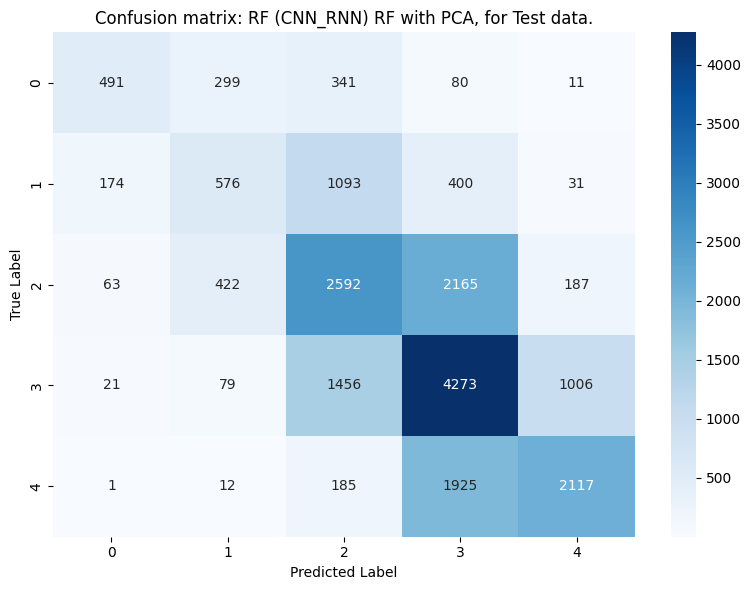


Confusion matrix plot displayed for 'Confusion matrix: RF (CNN_RNN) RF with PCA, for Test data.'.


(0.50245, 0.5103685348233105, 0.50245, 0.497531246336089)

In [50]:
model_str = 'RF (CNN_RNN) RF with PCA'
data_str = 'Test data.'
evaluate_classification_metrics(y_true_int_test, rf_test_predict, model_str, data_str)

In [29]:
print("\n--- Training and Evaluating XGBoost Model ---")

# پارامترهای اولیه XGBoost
xgb_params = {
    'objective': 'multi:softmax', # برای دسته‌بندی چند کلاسه با خروجی برچسب کلاس
    'num_class': 5,               # تعداد کلاس‌ها (0 تا 4)
    'eval_metric': 'mlogloss',    # معیاری برای ارزیابی در حین آموزش
    'n_estimators': 450,          # تعداد درخت‌ها
    'learning_rate': 0.01,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'use_label_encoder': False,   # برای جلوگیری از اخطار مربوط به آینده
    'random_state': 42,
    'n_jobs': -1
}

xgb_model = xgb.XGBClassifier(**xgb_params)

# آموزش مدل
xgb_model.fit(extracted_features_train, y_train) # y_train به جای y_train_encoded




--- Training and Evaluating XGBoost Model ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:25:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=-1, num_class=5, ...)

In [30]:
# پیش‌بینی روی داده‌های تست
y_pred_xgb = xgb_model.predict(extracted_features_test)




--- Classification Metrics ---
Accuracy: 0.4874
Weighted Precision: 0.4915
Weighted Recall: 0.4874
Weighted F1-score: 0.4817


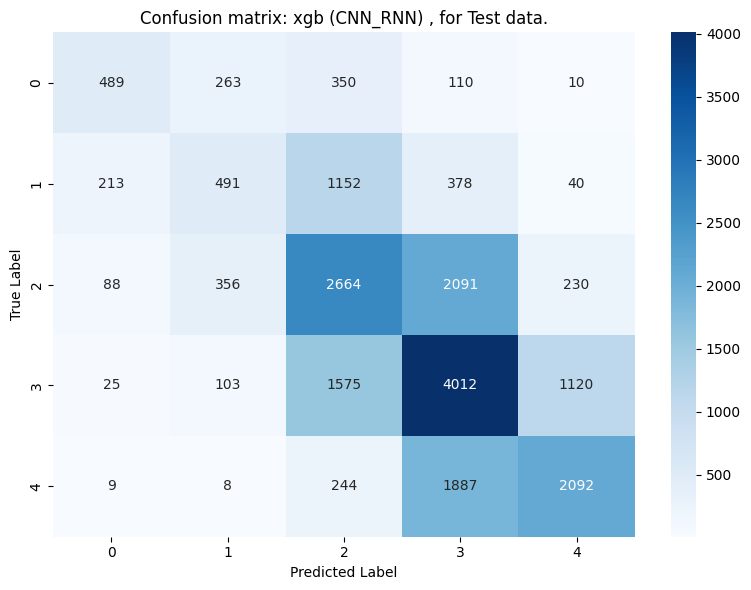


Confusion matrix plot displayed for 'Confusion matrix: xgb (CNN_RNN) , for Test data.'.


(0.4874, 0.49153787370843655, 0.4874, 0.4816601367090663)

In [31]:
model_str = 'xgb (CNN_RNN) '
data_str = 'Test data.'
evaluate_classification_metrics(y_true_int_test, y_pred_xgb, model_str, data_str)

In [ ]:
print("\n--- Running GridSearchCV for XGBoost (might take a while) ---")
param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='multi:softmax',
                                                            num_class=5, # تعداد کلاس ها
                                                            eval_metric='mlogloss',
                                                            use_label_encoder=False,
                                                            random_state=42),
                               param_grid=param_grid_xgb,
                               scoring='accuracy',
                               cv=3,
                               n_jobs=-1,
                               verbose=1)

xgb_grid_search.fit(extracted_features_train, y_train)


--- Running GridSearchCV for XGBoost (might take a while) ---
Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

In [ ]:
# print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
# print(f"Best cross-validation accuracy for XGBoost: {xgb_grid_search.best_score_:.4f}")

# y_pred_xgb_tuned = xgb_grid_search.predict(extracted_features_test)